# Section A: Convolutinal Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
Implement an image classifier using a deep learning network, to classify images into 11 classes of vegetables.<br/>
We will build two models for two different input sizes (23x23 and 101x101)<br/>
We want to compare the two classification models and their results

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import cv2
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
randomseed = 17

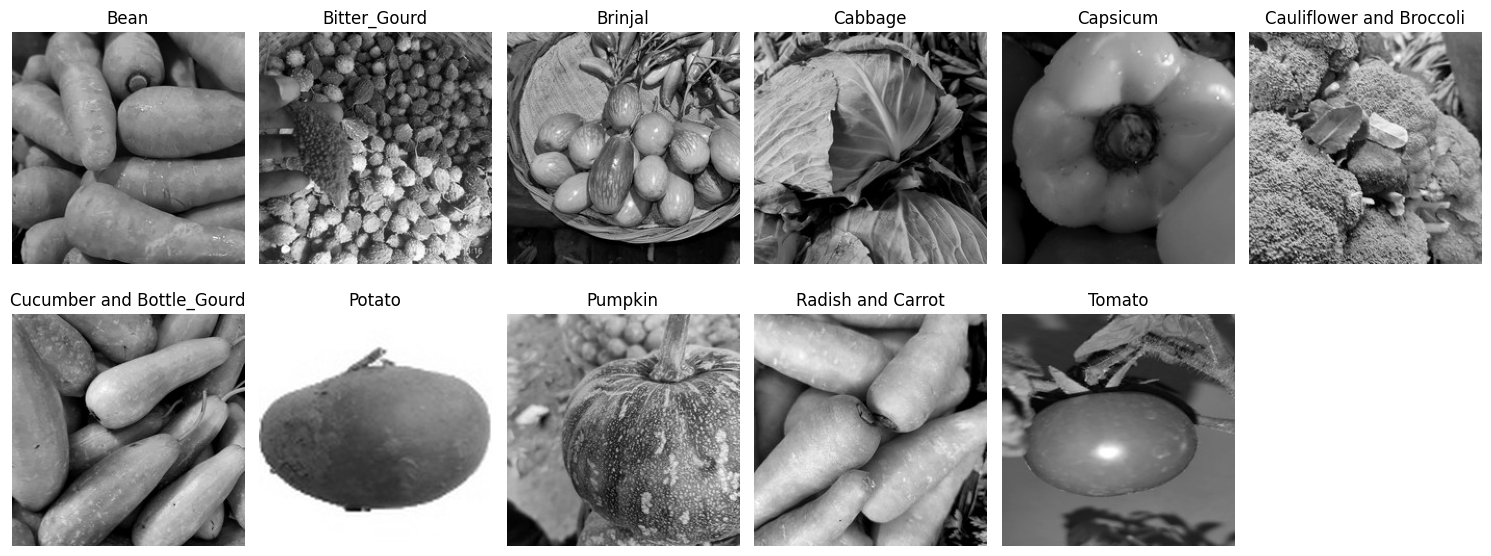

In [3]:
def show_images(folder_path):
    class_names = sorted(os.listdir(folder_path))
    plt.figure(figsize=(15, 6))
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(folder_path, cls)
        img_name = os.listdir(class_dir)[random.randint(0,9)]
        img = cv2.imread(os.path.join(class_dir, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images('Datasets/train')

# | Preprocess Data

In [4]:
import os

# Paths to dataset folders
base_path = 'Datasets'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

image_size_small = (23, 23)
image_size_large = (101, 101)

train_data_23 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
val_data_23 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
test_data_23 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')

train_data_101 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
val_data_101 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
test_data_101 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [34]:
def seperate_dataset_object(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image)
        y.append(label)
    X = tf.concat(X, axis=0).numpy()
    y = tf.concat(y, axis=0).numpy()
    return X, y

X_train_23, y_train_23 = seperate_dataset_object(train_data_23)
X_val_23, y_val_23 = seperate_dataset_object(val_data_23)
X_test_23, y_test_23 = seperate_dataset_object(test_data_23)

X_train_101, y_train_101 = seperate_dataset_object(train_data_101)
X_val_101, y_val_101 = seperate_dataset_object(val_data_101)
X_test_101, y_test_101 = seperate_dataset_object(test_data_101)

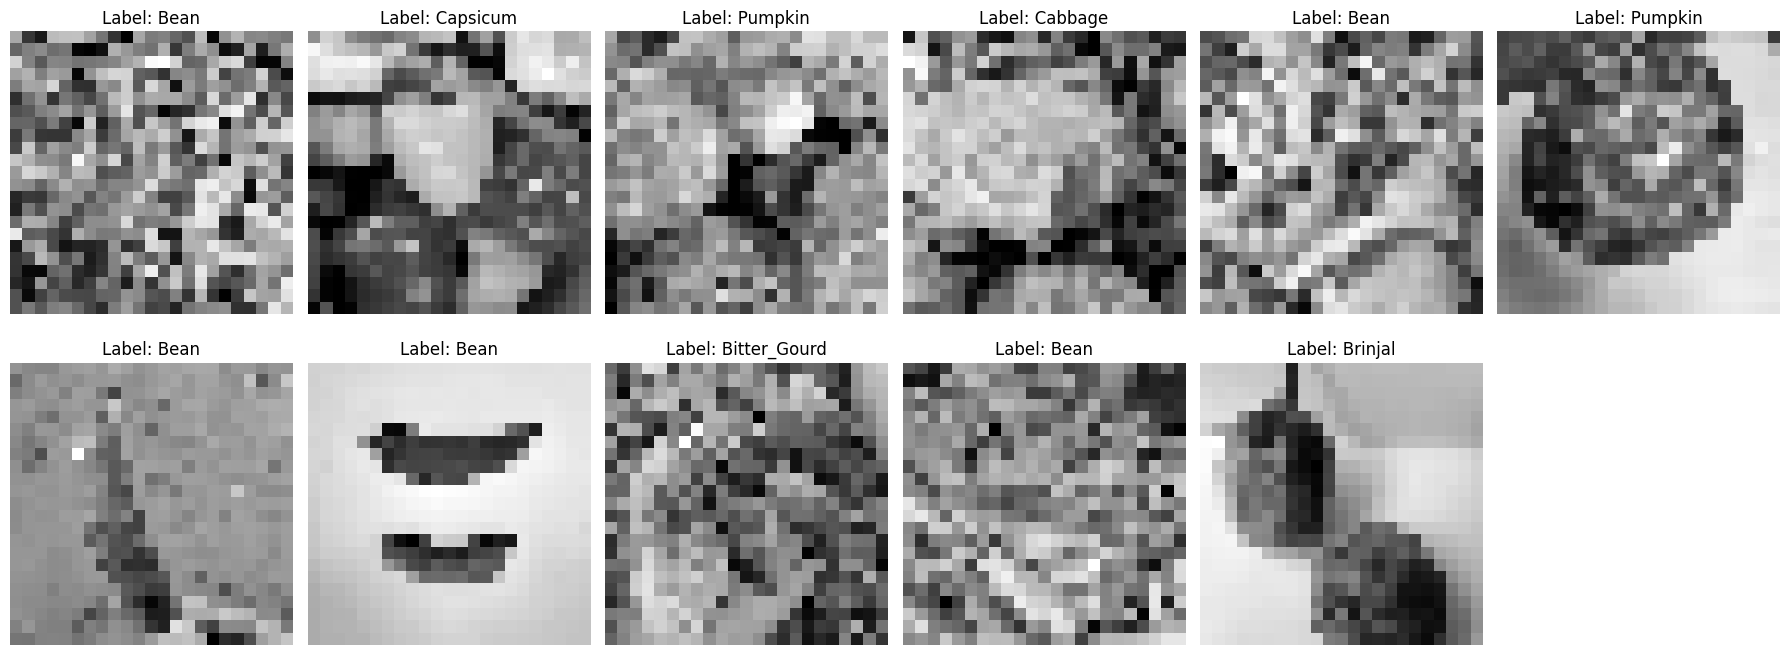

In [29]:
def show_sample_images(X, y, class_names):
    plt.figure(figsize=(18, 7))
    indices = random.sample(range(len(X)), len(class_names))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.title(f"Label: {class_names[y[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = sorted(os.listdir(train_path))
show_sample_images(X_train_23, y_train_23, class_names)

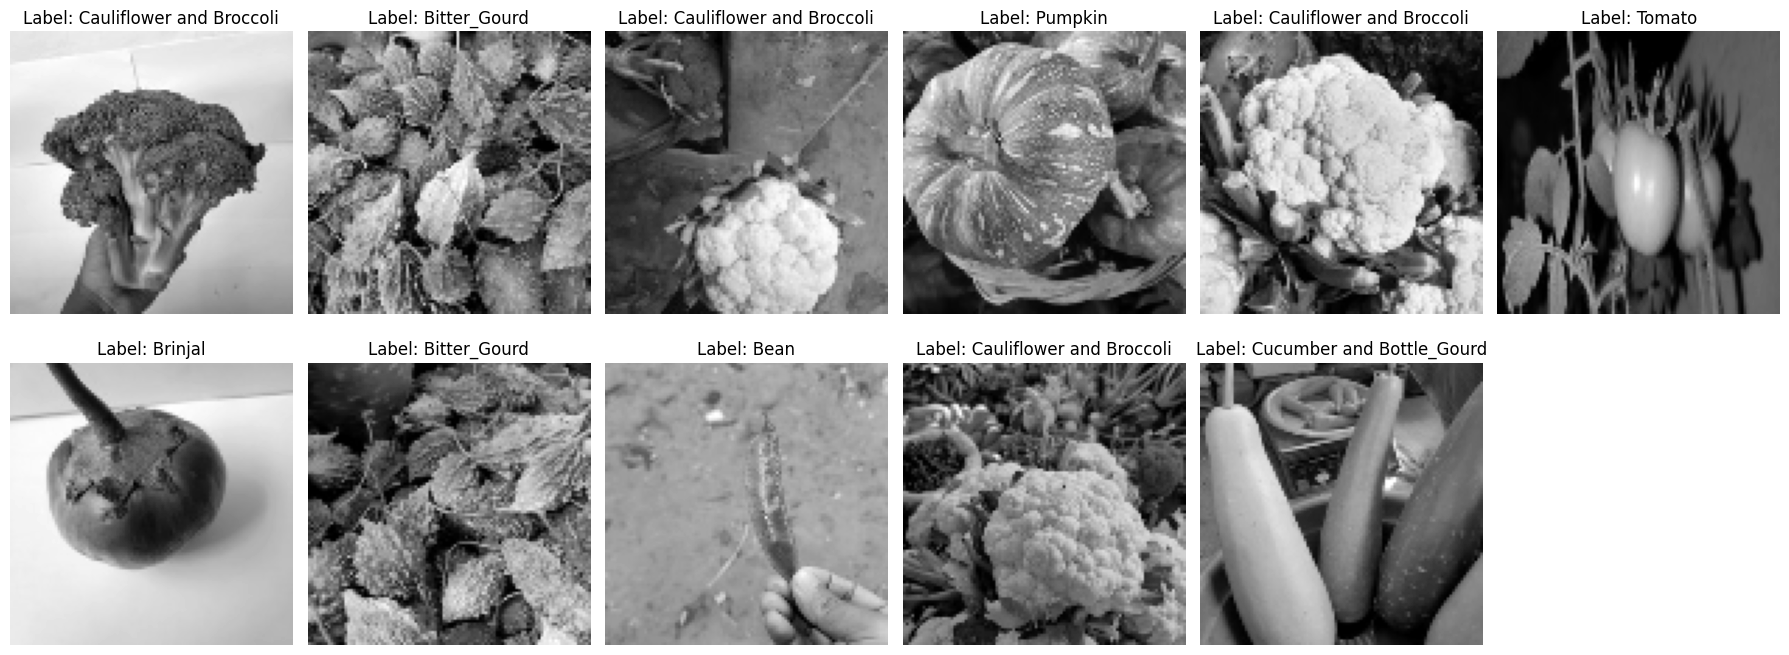

In [35]:
show_sample_images(X_train_101, y_train_101, class_names)

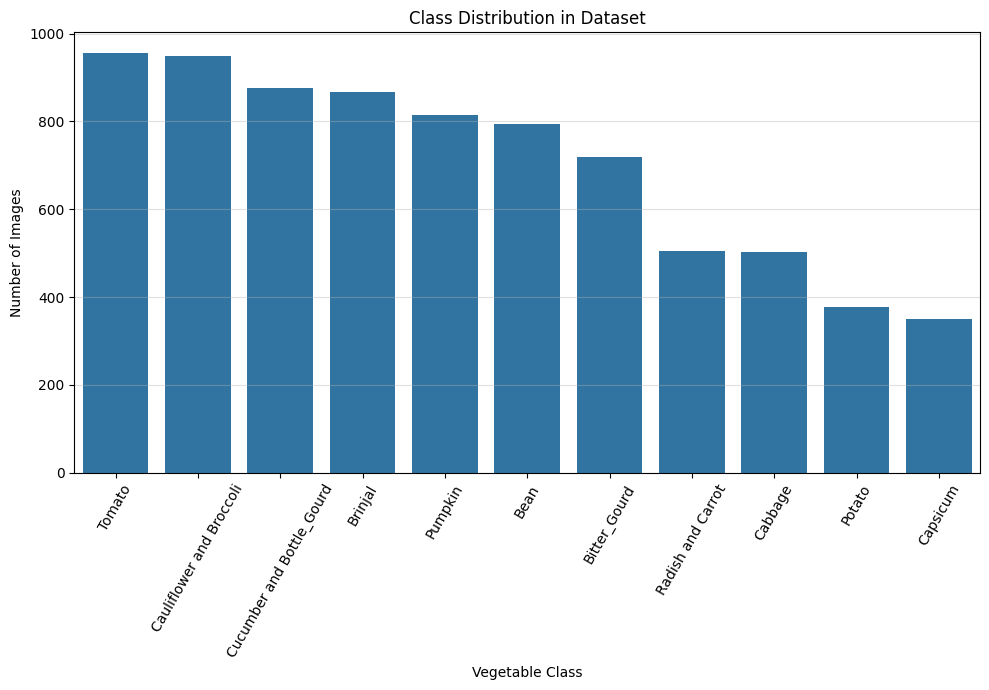

In [23]:
label_names = [class_names[idx] for idx in y_train_23]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

# | Model Training

In [36]:
from tensorflow.keras.utils import to_categorical

num_classes = len(class_names)
y_train_23_cat = to_categorical(y_train_23, num_classes)
y_val_23_cat = to_categorical(y_val_23, num_classes)
y_test_23_cat = to_categorical(y_test_23, num_classes)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 23, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [38]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    X_train_23, y_train_23_cat,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_23, y_val_23_cat)
)

Epoch 1/15
241/241 [==============================] - 12s 7ms/step - loss: 3.0155 - accuracy: 0.1084 - val_loss: 2.4016 - val_accuracy: 0.0909
Epoch 2/15
241/241 [==============================] - 1s 6ms/step - loss: 2.3675 - accuracy: 0.1193 - val_loss: 2.4105 - val_accuracy: 0.0909
Epoch 3/15
241/241 [==============================] - 1s 5ms/step - loss: 2.3572 - accuracy: 0.1197 - val_loss: 2.4203 - val_accuracy: 0.0909
Epoch 4/15
241/241 [==============================] - 1s 5ms/step - loss: 2.3521 - accuracy: 0.1239 - val_loss: 2.4287 - val_accuracy: 0.0909
Epoch 5/15
241/241 [==============================] - 1s 5ms/step - loss: 2.3525 - accuracy: 0.1237 - val_loss: 2.4359 - val_accuracy: 0.0909
Epoch 6/15
241/241 [==============================] - 1s 5ms/step - loss: 2.3486 - accuracy: 0.1239 - val_loss: 2.4409 - val_accuracy: 0.0909
Epoch 7/15
241/241 [==============================] - 1s 5ms/step - loss: 2.3479 - accuracy: 0.1240 - val_loss: 2.4450 - val_accuracy: 0.0909
Epoch

In [40]:
test_loss, test_acc = model.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 3ms/step - loss: 2.4539 - accuracy: 0.0909
Test accuracy: 0.09


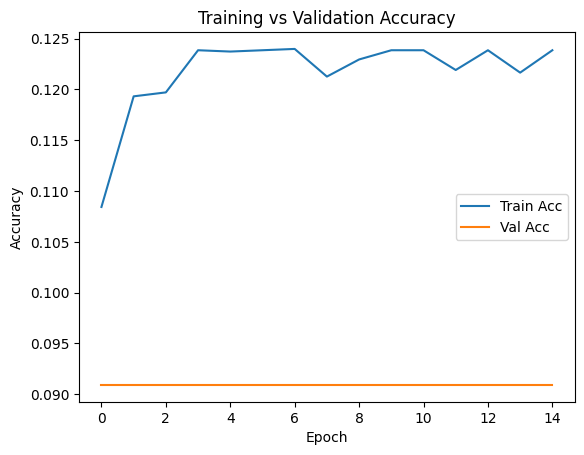

In [41]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()